# Time series forecasting with ARIMA and LSTM

The main purpose of this kernel, as being stated at the title, will be the analysis and forecasting of a time series using two different techniques: ARIMA and LSTM. The dataset we will use is the [DBLP - Publications per Year](https://www.kaggle.com/stefanosnikolaou/dblp-2020-05-01-pubs-per-year) dataset. So now, let's take a first look of our data: 



src: https://www.kaggle.com/code/stefanosnikolaou/time-series-forecasting-with-arima-and-lstm

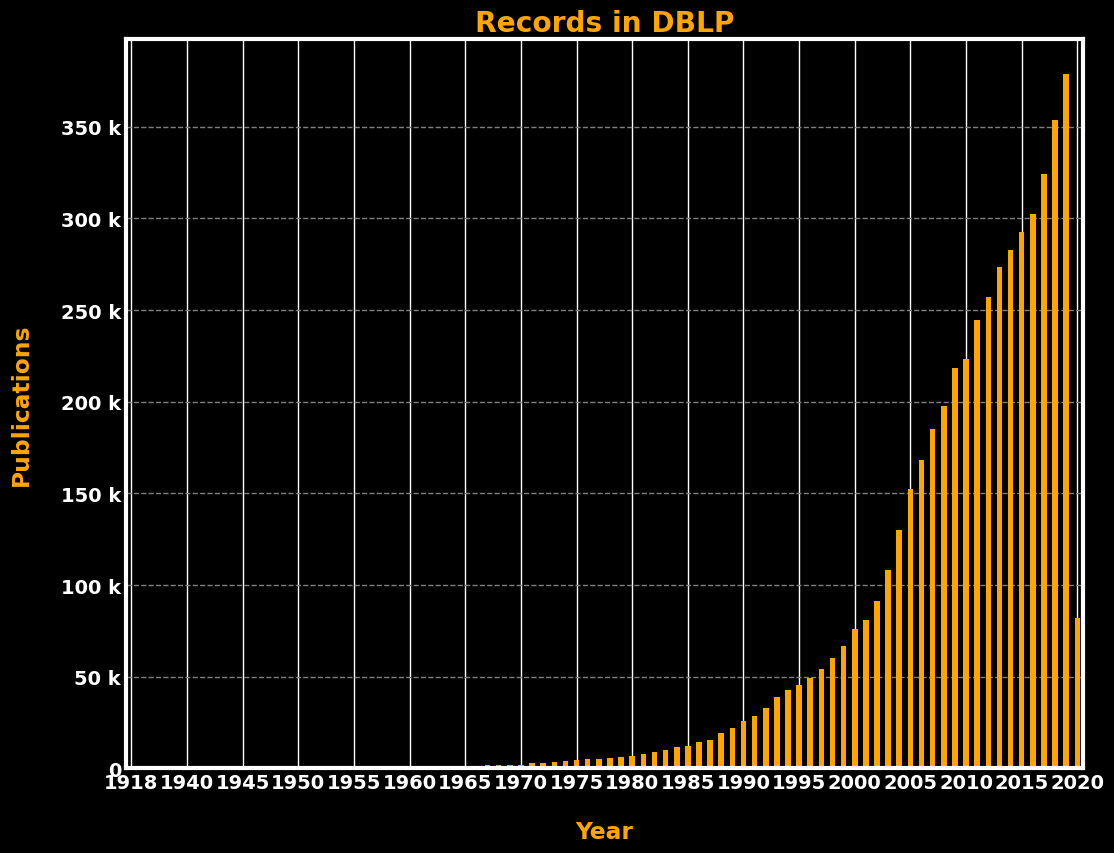

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

image_size = (11,9)

# Load data
df = pd.read_csv('pubs.csv')

# Draw plot
plt.style.use('dark_background')
plot = df.plot(kind = 'bar', x = 'Year', y = 'Pubs', color = 'orange', figsize = (image_size))

# Format plot
plt.title('Records in DBLP', fontweight ='bold', color = 'orange')
plt.xlabel('Year', labelpad = 20, fontweight ='bold', color = 'orange')
plt.ylabel('Publications', labelpad = 20, fontweight ='bold', color = 'orange',)

# Draw horizontal axis lines
axes = plt.gca()
axes.get_legend().remove()
axes.yaxis.grid(color = 'grey', linestyle = 'dashed')

# Format x axis ticks
l=np.array(df['Year'])
plt.xticks(range(0, len(l), 5), l[::5], rotation = 0, fontweight ='bold')

# Format y axis ticks
plot.yaxis.set_major_formatter(ticker.EngFormatter())
plt.yticks(fontweight ='bold')

plt.show()



For the purpose of forecasting we will remove the years 1918 and 2020 (for year 2020 there are available data only up until May). For both ARIMA and LSTM we will use as train data the information from years from 1936 until 2007 and test data the years from 2008 until 2019. Before moving on to build our model we have to check our time series for **stationarity**, **seasonality** and **trend**.

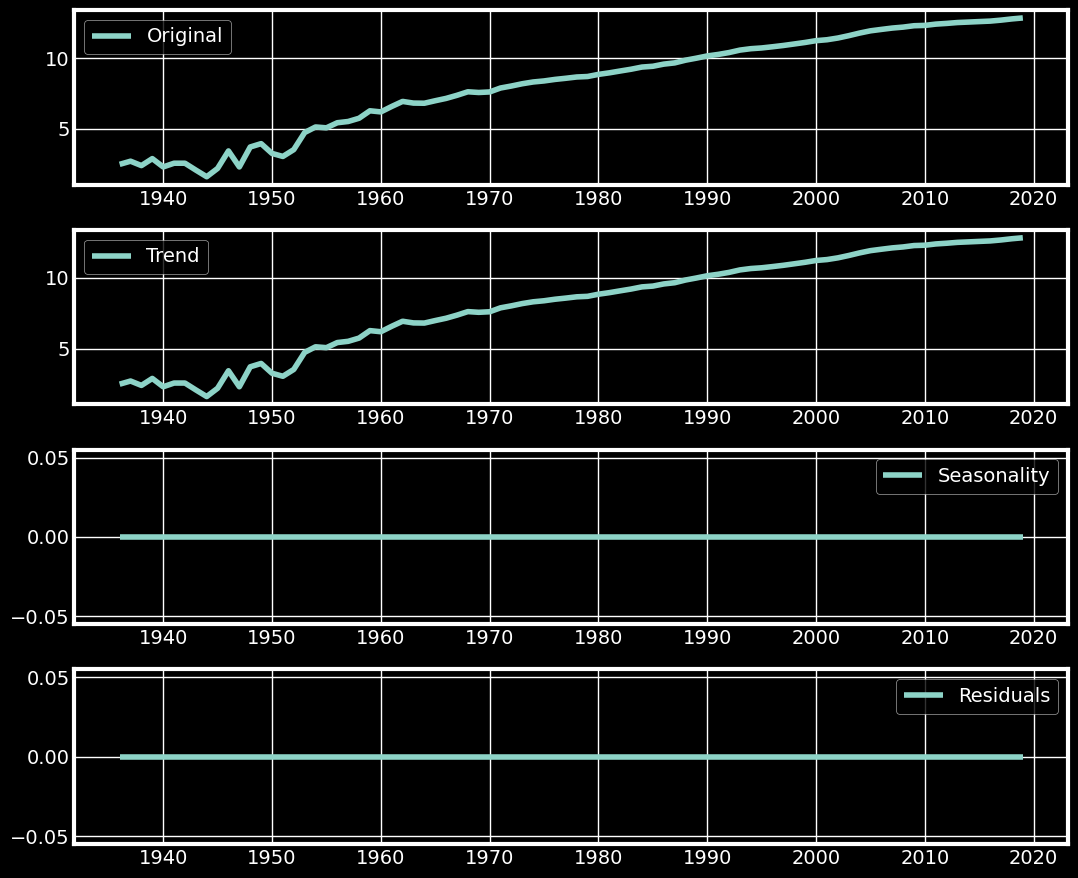

Results of Dickey-Fuller Test:
Test Statistic                 -1.405950
p-value                         0.579420
#Lags Used                     12.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
dtype: float64


In [108]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Load data
data = pd.read_csv('pubs_cut.csv',parse_dates=[0])
con = data['Year']
data['Year'] = pd.to_datetime(data['Year'])
data.set_index('Year', inplace=True)

# cCheck datatype of index
data.index

# Convert to time series:
ts = data['Pubs']

# Log transform time series
ts_log = np.log(ts)

# Create plots
decomposition = seasonal_decompose(ts_log)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize = image_size)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Perform Dickey-Fuller test:
print(
    'Results of Dickey-Fuller Test:')
dftest = adfuller(ts_log, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value
print(dfoutput)

From the above diagrams we see that there is no seasonality in our data and there is a strong uptrend. Moreover, by using the Dickey-Fuller test we get a p-value of 0,579 which  is not statistically significant (p-value>a=0,05) and indicates strong evidence for the null hypothesis. That means we can not reject the null hypothesis of the test (the data has a unit root and is non-stationary). [Here](https://pythondata.com/stationary-data-tests-for-time-series-forecasting/) is a helpful article.  

Since our time series proved to be non-stationary we can use an ARIMA(p,d,q) model to make it stationary by differencing. ARIMA stands for Autoregressive(**AR**) Integrated(**I**) Moving Αverage(**MA**) model and it consists of three parameters p, d and q:

* **p** - The number of Autoregressive terms
* **d** - The number of differences needed for stationarity
* **q** - The number of Moving Αverage terms

Another helpful article, written by Caner Dabakoglu, is this [one](https://medium.com/@cdabakoglu/time-series-forecasting-arima-lstm-prophet-with-python-e73a750a9887).

In order to select the values of p and q we will use the autocorrelation and partial autocorrelation graphs.

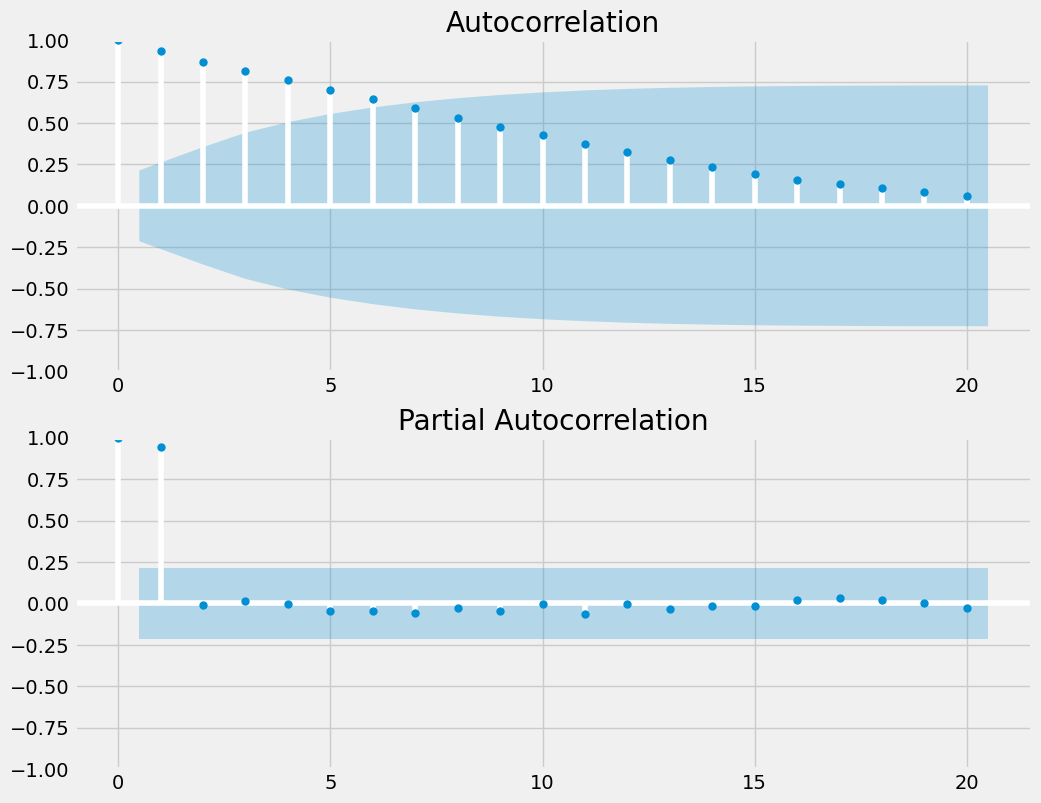

In [109]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Load data
df = pd.read_csv('pubs_cut.csv') 

# Set Year as index
df = df.set_index("Year")

# Create acf and pacf plots
plt.style.use('fivethirtyeight')
plt.figure(figsize = image_size)
ax1=plt.subplot(211)
plot_acf(df, ax=plt.gca(), lags=20)
plt.title('Autocorrelation', color='black')
ax1.tick_params(axis='y', colors='black')
ax1.tick_params(axis='x', colors='black')
ax2=plt.subplot(212)
plot_pacf(df, ax=plt.gca(), lags=20)
ax2.tick_params(axis='y', colors='black')
ax2.tick_params(axis='x', colors='black')
plt.title('Partial Autocorrelation', color='black')
#plt.axis(color='black')
plt.show()


## ARIMA (2,1,0)

After interpreting the acf and pacf plots we draw to the conclusion that the best model is the Autoregressive model – AR(2). More information about this interpretation can be found [here](https://www.linkedin.com/pulse/reading-acf-pacf-plots-missing-manual-cheatsheet-saqib-ali/). Additionally, since our time series is non-stationary we have to use at least one difference to make it stationary and that's why we set **d=1**. So for our first test we will use **ARIMA(2,1,0)**.

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import statistics
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

# Insert data without years 1918 & 2020
df = pd.read_csv('pubs_cut.csv', parse_dates=[0])

# Format 'Year' column as year type
df.Year = pd.to_datetime(df.Year).dt.year

# Build train and test set
train_data = df[:len(df)-12]
train_data = train_data.astype('float64')
test_data = df[len(df)-12:]
test_data = test_data.astype('float64')

# Build ARIMA model (2,1,0)
model = ARIMA(train_data['Pubs'], order=(2,1,0))
model_fit = model.fit()
arima_pred = model_fit.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Forecast")
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                   Pubs   No. Observations:                   72
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -625.051
Date:                Sun, 14 May 2023   AIC                           1256.102
Time:                        01:01:31   BIC                           1262.890
Sample:                             0   HQIC                          1258.802
                                 - 72                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1355      0.055     20.819      0.000       1.029       1.242
ar.L2         -0.1355      0.059     -2.279      0.023      -0.252      -0.019
sigma2      2.632e+06   2.23e+05     11.792      0.0

Mean is: 279182.75
RMSE = 19017.801981428824


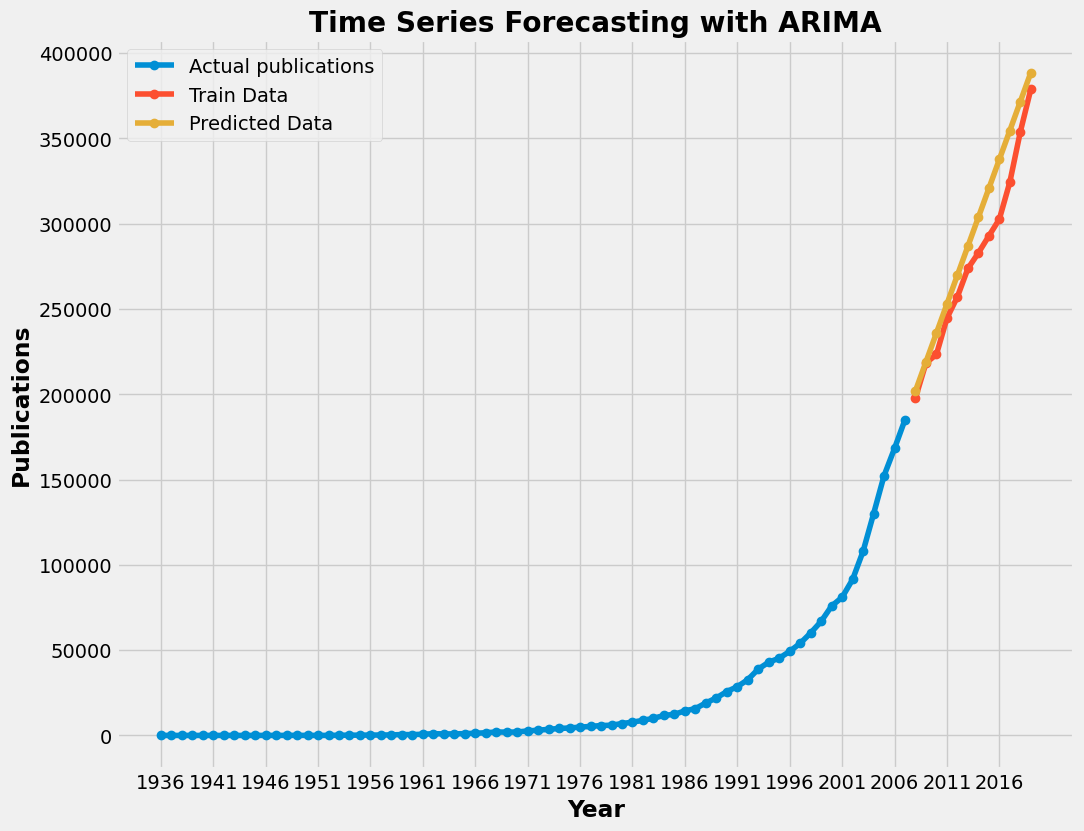

In [111]:
# Build plot
plt.style.use('fivethirtyeight')
train_data['Pubs'].plot(figsize = image_size, legend=True, marker='o')
test_data['Pubs'].plot(figsize = image_size, legend=True, marker='o')
plt.title("Time Series Forecasting with ARIMA", fontweight ='bold', color='black')
plt.xlabel('Year', fontweight ='bold', color='black')
plt.ylabel('Publications', fontweight ='bold', color='black')

# Format x axis ticks
plt.xlabel('Year')
l=np.array(df['Year'])
plt.xticks(range(0, len(l), 5), l[::5], rotation = 0, color='black')
plt.yticks(color='black')

# Add markers to predictions line
arima_pred.plot(legend = True, marker='o');

# Rename legend labels
L=plt.legend()
L.get_texts()[0].set_text('Actual publications')
L.get_texts()[1].set_text('Train Data')
L.get_texts()[2].set_text('Predicted Data')
plt.setp(L.get_texts(), color = 'black')

# Calculate test_data mean
x= statistics.mean(test_data['Pubs'])
print("Mean is:", x)

# Calculate RMSE
arima_rmse_error = rmse(test_data['Pubs'], arima_pred)
print(f'RMSE = {arima_rmse_error}')

plt.show()

In order to measure the accuracy of our forecast we will use the Root Mean Square Error – RMSE. For the **ARIMA(2,1,0)** model we have an **RMSE of 10556.69**, meaning the model was wrong by about 10.5k publications per year for each prediction made, while the mean publications per year are 279182.75  

Another approach to find the best ARIMA model is to run multiple combinations of p,d and q values and find the best fit based on which model has the lowest RMSE. By doing that we find out the **ARIMA(1,1,5)** was the most accurate model with **RMSE = 9483.94** 

## ARIMA (1,1,5)

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

warnings.filterwarnings("ignore")

# Insert data without years 1918 & 2020
df = pd.read_csv ('pubs_cut.csv', parse_dates=[0])

# Format 'Year' column as year type
df.Year = pd.to_datetime(df.Year).dt.year

# Build train and test set
train_data = df[:len(df)-12]
train_data = train_data.astype('float64')
test_data = df[len(df)-12:]
test_data = test_data.astype('float64')

def arima(p,d,q):
    try:
        try:
            model = ARIMA(train_data['Pubs'], order=(p,d,q))
            model_fit = model.fit()
            arima_pred = model_fit.predict(start=len(train_data), end=len(df) - 1, typ="levels").rename("ARIMA Forecast")
            arima_rmse_error = sqrt(mean_squared_error(test_data['Pubs'], arima_pred))
        except np.linalg.LinAlgError as e:
            arima_rmse_error=100000
    except ValueError as e:
        arima_rmse_error=100000
    return(arima_rmse_error)

for p in range (0,4):
    for d in range (0,3):
        for q in range  (0,7):
            arima_rmse_error=arima(p,d,q)
            if q == 0 and d == 0 and p == 0:
                rmse = arima_rmse_error
            if rmse > arima_rmse_error:
                rmse = arima_rmse_error
                P,D,Q=p,d,q

model = ARIMA(train_data['Pubs'], order=(P, D, Q))
model_fit = model.fit()
arima_pred = model_fit.predict(start=len(train_data), end=len(df) - 1, typ="levels").rename("ARIMA Forecast")
arima_rmse_error = sqrt(mean_squared_error(test_data['Pubs'], arima_pred))
print(model_fit.summary())

# Calculate test_data mean
x= statistics.mean(test_data['Pubs'])
print("Mean is :", x)
plt.show()

# Show RMSE
print(f'RMSE = {arima_rmse_error}')
#print(f'MSE={mean_squared_error(test_data["Pubs"], arima_pred)}')
#print(f'MAE={mean_absolute_error(test_data["Pubs"], arima_pred)}')

test_data["ARIMA"] = arima_pred 

                               SARIMAX Results                                
Dep. Variable:                   Pubs   No. Observations:                   72
Model:                 ARIMA(3, 0, 4)   Log Likelihood                -640.122
Date:                Sun, 14 May 2023   AIC                           1298.243
Time:                        01:01:43   BIC                           1318.733
Sample:                             0   HQIC                          1306.400
                                 - 72                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.251e+04   6.02e-08   3.74e+11      0.000    2.25e+04    2.25e+04
ar.L1          1.4015      0.148      9.459      0.000       1.111       1.692
ar.L2          0.1492      0.314      0.475      0.6

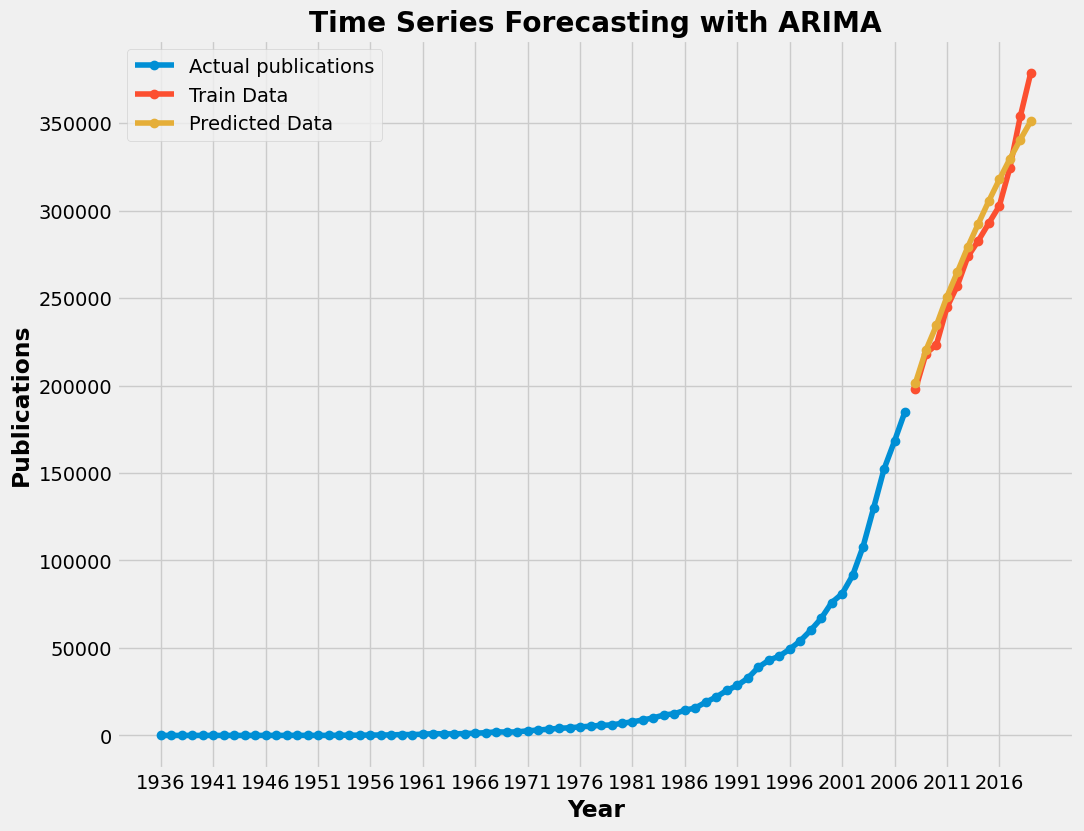

In [113]:
# Build plot
plt.style.use('fivethirtyeight')
train_data['Pubs'].plot(figsize = image_size, legend=True, marker='o')
test_data['Pubs'].plot(figsize = image_size, legend=True, marker='o')
plt.title("Time Series Forecasting with ARIMA", fontweight ='bold', color='black')
plt.xlabel('Year', fontweight ='bold', color='black')
plt.ylabel('Publications', fontweight ='bold', color='black')

# Format x axis ticks
plt.xlabel('Year')
l=np.array(df['Year'])
plt.xticks(range(0, len(l), 5), l[::5], rotation = 0, color='black')
plt.yticks(color='black')

# Add markers to predictions line
arima_pred.plot(legend = True, marker='o');

# Rename legend labels
L=plt.legend()
L.get_texts()[0].set_text('Actual publications')
L.get_texts()[1].set_text('Train Data')
L.get_texts()[2].set_text('Predicted Data')
plt.setp(L.get_texts(), color = 'black')

plt.show()

## LSTM

In [114]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
import pandas as pd

# datetime parsing function for loading the dataset

def parser(x):
   return datetime.strptime(x, '%Y')

# frame a sequence as a supervised learning problem

def timeseries_to_supervised(data, lag=1):
   df = DataFrame(data)
   columns = [df.shift(i) for i in range(1, lag+1)]
   columns.append(df)
   df = concat(columns, axis=1)
   df.fillna(0, inplace=True)
   return df

# create a differenced series

def difference(dataset, interval=1):
   diff = list()
   for i in range(interval, len(dataset)):
      value = dataset[i] - dataset[i - interval]
      diff.append(value)
   return Series(diff)

# invert differenced value

def inverse_difference(history, yhat, interval=1):
   return yhat + history[-interval]

# scale train and test data to [-1, 1]

def scale(train, test):
   # fit scaler
   scaler = MinMaxScaler(feature_range=(-1, 1))
   scaler = scaler.fit(train)
   # transform train
   train = train.reshape(train.shape[0], train.shape[1])
   train_scaled = scaler.transform(train)
   # transform test
   test = test.reshape(test.shape[0], test.shape[1])
   test_scaled = scaler.transform(test)
   return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value

def invert_scale(scaler, X, value):
   new_row = [x for x in X] + [value]
   array = numpy.array(new_row)
   array = array.reshape(1, len(array))
   inverted = scaler.inverse_transform(array)
   return inverted[0, -1]

# fit an LSTM network to training data

def fit_lstm(train, batch_size, nb_epoch, neurons):
   X, y = train[:, 0:-1], train[:, -1]
   X = X.reshape(X.shape[0], 1, X.shape[1])
   model = Sequential()
   model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
   model.add(Dense(1))
   model.compile(loss='mean_squared_error', optimizer='adam')
   for i in range(nb_epoch):
      model.fit(X, y, epochs=10, batch_size=batch_size, verbose=1, shuffle=False)
      model.reset_states()
   return model

# make a one-step forecast

def forecast_lstm(model, batch_size, X):
   X = X.reshape(1, 1, len(X))
   yhat = model.predict(X, batch_size=batch_size)
   return yhat[0,0]

# load dataset

series = read_csv('pubs_cut.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# transform data to be stationary

raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning

supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets

train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data

scaler, train_scaled, test_scaled = scale(train, test)

# fit the model

lstm_model = fit_lstm(train_scaled, 1, 3, 4)

# forecast the entire training dataset to build up state for forecasting

train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data

predictions = list()
for i in range(len(test_scaled)):
   # make one-step forecast
   X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
   yhat = forecast_lstm(lstm_model, 1, X)
   # invert scaling
   yhat = invert_scale(scaler, X, yhat)
   # invert differencing
   yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
   # store forecast
   predictions.append(yhat)
   expected = raw_values[len(train) + i + 1]
   print('Year=%d, Predicted=%f, Expected=%f' % (i+2008, yhat, expected))

# report performance

rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)

# line plot of observed vs predicted

b = numpy.arange(1936, 2020, 1)
df1 = pd.DataFrame(b)
df2 = pd.DataFrame(raw_values)
df3 = pd.DataFrame(predictions)
for i in range (0,72):
   df3.loc[len(df3)] = numpy.nan
   df3 = df3.shift()
   df3.loc[0] = numpy.nan
print(df3)
pdlist=[df1,df2,df3]
df1.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)
df3.reset_index(drop=True, inplace=True)
df = pd.concat(pdlist, axis=1)
df.columns=['Year','Actual Values','Predicted Values']
print(df)

test_data['LSTM'] = predictions

Epoch 1/10
71/71 [==============================] - 1s 3ms/step - loss: 0.5895
Epoch 2/10
71/71 [==============================] - 0s 3ms/step - loss: 0.2218
Epoch 3/10
71/71 [==============================] - 0s 3ms/step - loss: 0.1227
Epoch 4/10
71/71 [==============================] - 0s 3ms/step - loss: 0.1114
Epoch 5/10
71/71 [==============================] - 0s 3ms/step - loss: 0.1017
Epoch 6/10
71/71 [==============================] - 0s 3ms/step - loss: 0.0928
Epoch 7/10
71/71 [==============================] - 0s 3ms/step - loss: 0.0847
Epoch 8/10
71/71 [==============================] - 0s 3ms/step - loss: 0.0775
Epoch 9/10
71/71 [==============================] - 0s 3ms/step - loss: 0.0711
Epoch 10/10
71/71 [==============================] - 0s 3ms/step - loss: 0.0657
Epoch 1/10
71/71 [==============================] - 0s 3ms/step - loss: 0.0489
Epoch 2/10
71/71 [==============================] - 0s 3ms/step - loss: 0.0580
Epoch 3/10
71/71 [==============================] -

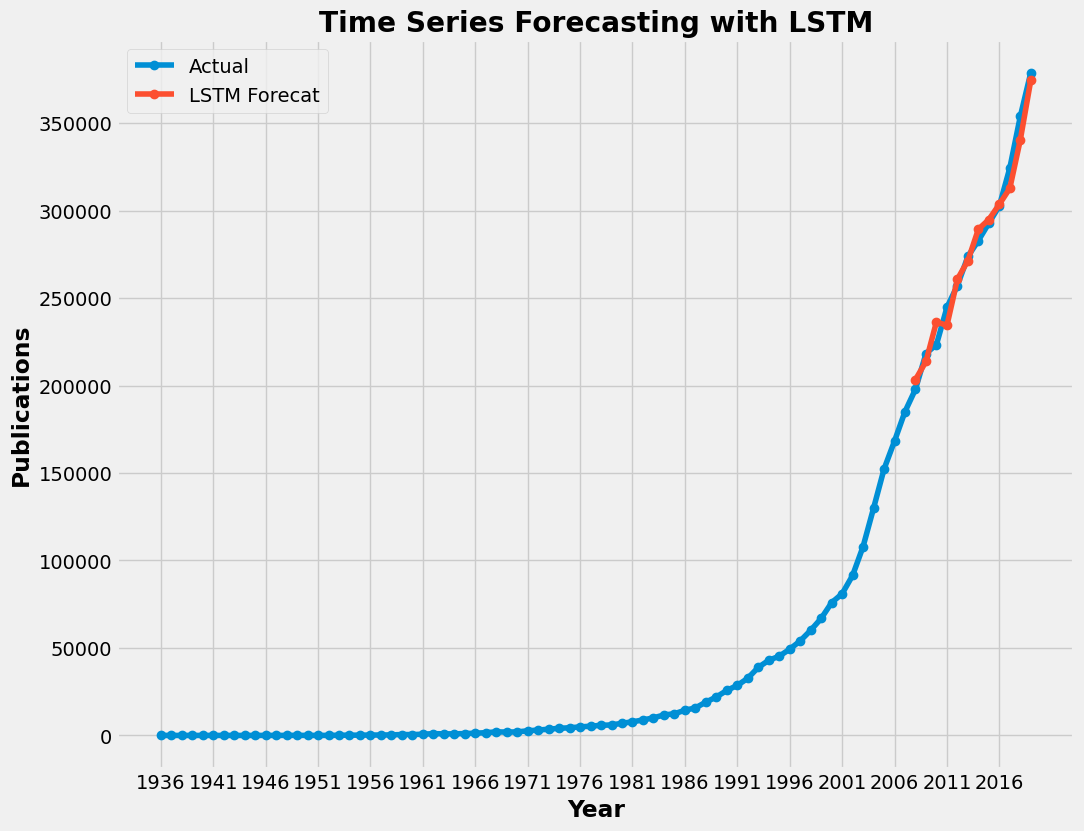

In [115]:
# Draw plot

pyplot.style.use('fivethirtyeight')
plt.figure(figsize = image_size)
pyplot.plot(df['Actual Values'], marker='o', label="Actual")
pyplot.plot(df['Predicted Values'], marker='o', label="LSTM Forecat")
pyplot.title("Time Series Forecasting with LSTM", fontweight ='bold', color = 'black')
pyplot.xlabel('Year', fontweight ='bold', color = 'black')
pyplot.ylabel('Publications', fontweight ='bold', color = 'black')
a=numpy.array(df['Year'])
pyplot.xticks(range(0, len(a), 5), a[::5], rotation = 0, color = 'black')
pyplot.yticks(color = 'black')
L=plt.legend()
L.get_texts()[0]
L.get_texts()[1]
plt.setp(L.get_texts(), color = 'black')

pyplot.show()

## Comparison

Comparing the two forecasting models created with **ARIMA (RMSE = 9483.94)** and LSTM **(RMSE = 7667.14)** we draw to the conclusion that the best fit (the one with the smallest RMSE) for our time series is the LSTM, despite we have noticed it incorporates an element of randomness. Nonetheless, it is the most accurate of the two models. 




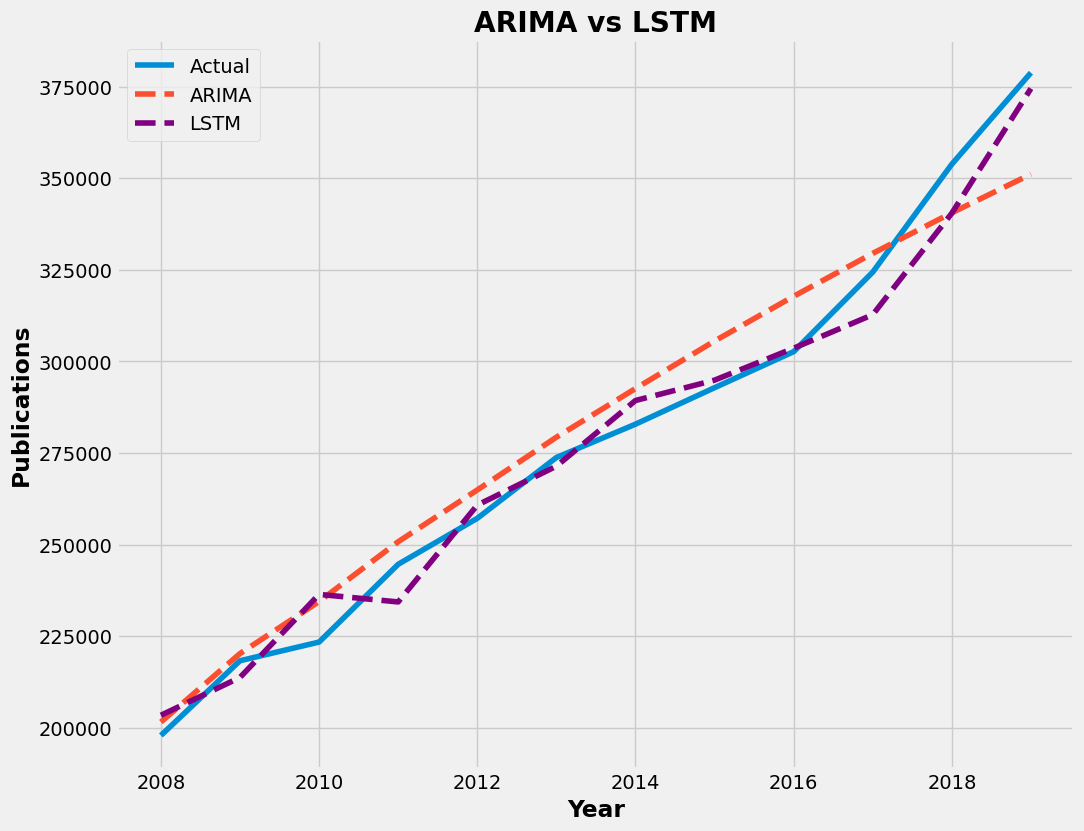

In [116]:
# Draw comparison plot
                  
pyplot.style.use('fivethirtyeight')
plt.figure(figsize = image_size)
plt.plot(test_data['Year'], test_data["Pubs"], label="Actual",)
plt.plot(test_data['Year'], test_data["ARIMA"], linestyle="--", label="ARIMA")
plt.plot(test_data['Year'], test_data["LSTM"], linestyle="--", label="LSTM", color="purple")
pyplot.title("ARIMA vs LSTM", fontweight ='bold', color = 'black')
pyplot.xlabel('Year', fontweight ='bold', color = 'black')
pyplot.ylabel('Publications', fontweight ='bold', color = 'black')
pyplot.xticks(color = 'black')
pyplot.yticks(color = 'black')
L=plt.legend()
L.get_texts()[0]
L.get_texts()[1]
L.get_texts()[2]
plt.setp(L.get_texts(), color = 'black')

plt.show()

Ошибки ARIMA и RNN

In [122]:
print(f'ARIMA RMSE = {arima_rmse_error}')
print(f'ARIMA MSE = {mean_squared_error(test_data["Pubs"], test_data["ARIMA"])}')
print(f'ARIMA MAE = {mean_absolute_error(test_data["Pubs"], test_data["ARIMA"])}')
print('')
print(f'RNN RMSE = {rmse}')
print(f'RNN MSE = {mean_squared_error(test_data["Pubs"], test_data["LSTM"])}')
print(f'RNN MAE = {mean_absolute_error(test_data["Pubs"], test_data["LSTM"])}')

ARIMA RMSE = 11980.4737268851
ARIMA MSE = 143531750.72058418
ARIMA MAE = 9981.953542245361

RNN RMSE = 7758.953978288094
RNN MSE = 60306686.08730298
RNN MAE = 6507.2932688221335


## Forecast for 2020

Finally, we decided to make a forecast for 2020. The model predicted that during 2020 there will be 397264 publications.

In [118]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
import pandas as pd

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime(x, '%Y')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=10, batch_size=batch_size, verbose=1, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# load dataset
series = read_csv('pubs.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)[1:]

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-13], supervised_values[-13:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Year=%d, Predicted=%f, Expected=%f' % (i+2008, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-13:-1], predictions[-13:-1]))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted

b = numpy.arange(1936, 2021, 1)
df1 = pd.DataFrame(b)
df2 = pd.DataFrame(raw_values)
df3 = pd.DataFrame(predictions)
for i in range (0,72):
	df3.loc[len(df3)] = numpy.nan
	df3 = df3.shift()
	df3.loc[0] = numpy.nan
pdlist=[df1,df2,df3]
df1.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)
df3.reset_index(drop=True, inplace=True)
df = pd.concat(pdlist, axis=1)
df.columns=['Year','Actual Values','Predicted Values']
print(df)

Epoch 1/10
71/71 [==============================] - 1s 3ms/step - loss: 0.4401
Epoch 2/10
71/71 [==============================] - 0s 3ms/step - loss: 0.2112
Epoch 3/10
71/71 [==============================] - 0s 3ms/step - loss: 0.1485
Epoch 4/10
71/71 [==============================] - 0s 3ms/step - loss: 0.1309
Epoch 5/10
71/71 [==============================] - 0s 3ms/step - loss: 0.1224
Epoch 6/10
71/71 [==============================] - 0s 3ms/step - loss: 0.1155
Epoch 7/10
71/71 [==============================] - 0s 3ms/step - loss: 0.1090
Epoch 8/10
71/71 [==============================] - 0s 3ms/step - loss: 0.1028
Epoch 9/10
71/71 [==============================] - 0s 3ms/step - loss: 0.0968
Epoch 10/10
71/71 [==============================] - 0s 2ms/step - loss: 0.0910
Epoch 1/10
71/71 [==============================] - 0s 2ms/step - loss: 0.0758
Epoch 2/10
71/71 [==============================] - 0s 3ms/step - loss: 0.0805
Epoch 3/10
71/71 [==============================] -

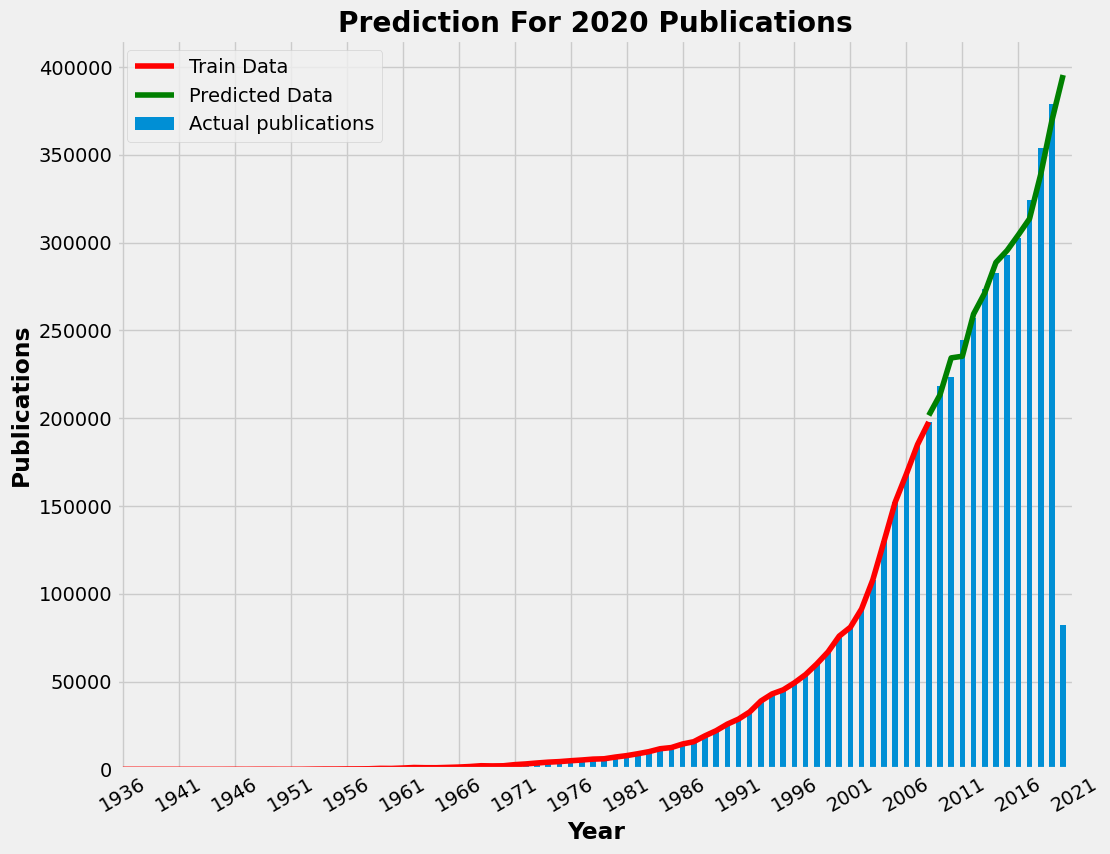

In [119]:
# Draw plot

pyplot.style.use('fivethirtyeight')
ax=df.plot.bar(x='Year', y='Actual Values', legend=True, figsize = image_size)
df[:-12].plot(y='Actual Values', linestyle='-',ax=ax,color='red',  legend=True)
df.plot(y='Predicted Values', linestyle='-',ax=ax,color='green',  legend=True)
plt.title('Prediction For 2020 Publications',fontweight ='bold', color = 'black')
plt.xlabel('Year', fontweight ='bold', color='black')
plt.ylabel('Publications', fontweight ='bold', color='black')
a = numpy.arange(1936, 2022, 1)
plt.xticks(range(0, len(a), 5), a[::5], rotation = 30, color='black')
plt.yticks(color='black')
L=pyplot.legend()
L.get_texts()[2].set_text('Actual publications')
L.get_texts()[0].set_text('Train Data')
L.get_texts()[1].set_text('Predicted Data')
plt.setp(L.get_texts(), color = 'black')

pyplot.show()